In [2]:
from tsl.data import SpatioTemporalDataset, SpatioTemporalDataModule, ImputationDataset
from tsl.data.preprocessing import StandardScaler
from tsl.datasets import AirQuality, MetrLA, PemsBay
from tsl.ops.imputation import add_missing_values
from MMD import mmd_rbf, mmd_linear
from tsl.engines import Imputer
from tsl.transforms import MaskInput
from tsl.nn.models import GRINModel
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from tsl.utils.casting import torch_to_numpy
from tsl.metrics import torch as torch_metrics
import matplotlib.pyplot as plt
import torch


In [3]:
p_fault, p_noise = 0.0015, 0.05
dataset = add_missing_values(PemsBay(),
                                p_fault=p_fault,
                                p_noise=p_noise,
                                min_seq=12,
                                max_seq=12 * 4,
                                seed=56789)
    
adj = dataset.get_connectivity(**{'method': 'distance',
'threshold': 0.1,
'include_self': False,
'layout': 'edge_index'
})

# instantiate dataset
torch_dataset = ImputationDataset(target=dataset.dataframe(),
                                    mask=dataset.training_mask,
                                    eval_mask=dataset.eval_mask,
                                    covariates=None,
                                    transform=MaskInput(),
                                    connectivity=adj,
                                    window=1,
                                    stride=1)


scalers = {'target': StandardScaler(axis=(0, 1))}
dm = SpatioTemporalDataModule(
    dataset=torch_dataset,
    scalers=scalers,
    splitter=dataset.get_splitter(**{'val_len': 0.2, 'test_len': 0.1}),
    batch_size=1,
    workers=8)
dm.setup(stage='fit')
dm.trainset = list(range(len(torch_dataset)))

In [4]:
loss_fn = torch_metrics.MaskedMAE()

log_metrics = {
    'mae': torch_metrics.MaskedMAE(),
    'mse': torch_metrics.MaskedMSE(),
    'mape': torch_metrics.MaskedMAPE(),
}
# setup generator
imputer = Imputer.load_from_checkpoint('pred_model.ckpt')

In [5]:
trainer = Trainer()

trainer.ckpt_path= 'pred_model.ckpt'

imputer.freeze()

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [6]:
output = trainer.predict(imputer, dataloaders=dm.test_dataloader())
output = imputer.collate_prediction_outputs(output)
output = torch_to_numpy(output)
y_hat, y_true = (output['y_hat'], output['y'])
res = dict(test_mae=loss_fn(torch.tensor(y_hat), torch.tensor(y_true)))
res

Restoring states from the checkpoint path at pred_model.ckpt
Loaded model weights from the checkpoint at pred_model.ckpt
/Users/paulmagos/.pyenv/versions/Thesis/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:419: Consider setting `persistent_workers=True` in 'predict_dataloader' to speed up the dataloader worker initialization.


Predicting DataLoader 0:   0%|          | 0/5212 [00:00<?, ?it/s]

Only args ['edge_weight', 'x', 'mask', 'edge_index'] are forwarded to the model (GRINModel).


Predicting DataLoader 0: 100%|██████████| 5212/5212 [03:16<00:00, 26.46it/s]


{'test_mae': tensor(3.3183)}

In [7]:
y_true = torch.tensor(y_true)
y_hat = torch.tensor(y_hat)

In [8]:
X = y_true.reshape(y_true.shape[0], -1)
Y = y_hat.reshape(y_true.shape[0], -1)
pred = scalers['target'].inverse_transform(Y)

mmd_rbf(torch.Tensor(X), torch.Tensor(Y))

0.00038377929013222456

In [9]:
mmd_linear(torch.Tensor(X), torch.Tensor(Y))

/Users/paulmagos/Documents/TSGen/MMD.py:23: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3679.)
  return delta.dot(delta.T)


tensor(1368.6128)

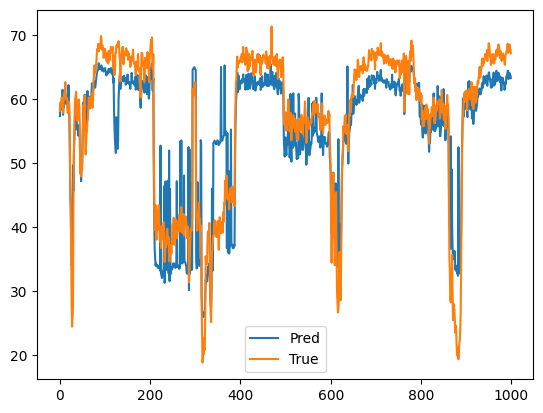

In [14]:
plt.plot(Y[-1000:, 10], label='Pred')
plt.plot(X[-1000:, 10], label='True')
plt.legend()

In [15]:
import pandas as pd

In [21]:
df = df[-1000:].reset_index(drop=True)

In [23]:
df.to_csv('GRINPemsBayPrediction.csv', index=False)

In [16]:
cols = [400001,400017,400030,400040,400045,400052,400057,400059,400065,400069,400073,400084,400085,400088,400096,400097,400100,400104,400109,400122,400147,400148,400149,400158,400160,400168,400172,400174,400178,400185,400201,400206,400209,400213,400221,400222,400227,400236,400238,400240,400246,400253,400257,400258,400268,400274,400278,400280,400292,400296,400298,400330,400336,400343,400353,400372,400394,400400,400414,400418,400429,400435,400436,400440,400449,400457,400461,400464,400479,400485,400499,400507,400508,400514,400519,400528,400545,400560,400563,400567,400581,400582,400586,400637,400643,400648,400649,400654,400664,400665,400668,400673,400677,400687,400688,400690,400700,400709,400713,400714,400715,400717,400723,400743,400750,400760,400772,400790,400792,400794,400799,400804,400822,400823,400828,400832,400837,400842,400863,400869,400873,400895,400904,400907,400911,400916,400922,400934,400951,400952,400953,400964,400965,400970,400971,400973,400995,400996,401014,401129,401154,401163,401167,401210,401224,401327,401351,401388,401391,401400,401403,401440,401457,401464,401489,401495,401507,401534,401541,401555,401560,401567,401597,401606,401611,401655,401808,401809,401810,401811,401816,401817,401845,401846,401890,401891,401906,401908,401926,401936,401937,401942,401943,401948,401957,401958,401994,401996,401997,401998,402056,402057,402058,402059,402060,402061,402067,402117,402118,402119,402120,402121,402281,402282,402283,402284,402285,402286,402287,402288,402289,402359,402360,402361,402362,402363,402364,402365,402366,402367,402368,402369,402370,402371,402372,402373,403225,403265,403329,403401,403402,403404,403406,403409,403412,403414,403419,404370,404434,404435,404444,404451,404452,404453,404461,404462,404521,404522,404553,404554,404585,404586,404640,404753,404759,405613,405619,405701,407150,407151,407152,407153,407155,407157,407161,407165,407172,407173,407174,407176,407177,407179,407180,407181,407184,407185,407186,407187,407190,407191,407194,407200,407202,407204,407206,407207,407321,407323,407325,407328,407331,407332,407335,407336,407337,407339,407341,407342,407344,407348,407352,407359,407360,407361,407364,407367,407370,407372,407373,407374,407710,407711,408907,408911,409524,409525,409526,409528,409529,413026,413845,413877,413878,414284,414694]

In [17]:
df = pd.DataFrame(Y, columns=cols)